In [1]:
# load dataset 
import pandas as pd 
from sklearn.model_selection import train_test_split
from keras import models
from keras import layers
from sklearn.feature_extraction.text import CountVectorizer
from keras.preprocessing.text import Tokenizer
from keras.utils import to_categorical
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.feature_extraction.text import TfidfVectorizer 


pathLyrics = 'lyrics-data.csv'
pathArtists = 'artists-data.csv'


dataframe = pd.read_csv(pathLyrics)
dataframeArtists = pd.read_csv(pathArtists)

Using TensorFlow backend.


In [2]:
# filter Idiom for olny english lyrics
dataframe = dataframe[dataframe['Idiom'] == 'ENGLISH']

In [3]:
# normalize lycris to lowercase  
dataframe['Lyric'] = dataframe['Lyric'].apply(lambda lyric: lyric.lower())

# Zwei csv werden gemerged
mergeData=pd.merge(dataframe, dataframeArtists, how='inner', left_on='ALink', right_on='Link')

#Filtern der Daten. Nur Lyric und Genre für das Dataset notwendig
rawData= mergeData[['Lyric', 'Genre']]

# Speichern der csv zum Anschauen
# dataset.to_csv('dataset.csv') 

In [4]:
# Es werden die Spalten gefiltert, die Noten enthalten
rawData = rawData[~rawData['Lyric'].str.contains('----')] 

#Filtert alle Zeichen bis auf Buchstaben und Zahlen heraus
rawData['Lyric']=rawData['Lyric'].str.replace('[^a-zA-Z0-9]', ' ')


In [5]:
train, test = train_test_split(rawData, test_size=0.2)

#Zu Testzwecken kann man die große beschränken
#train = train.head(10)
#test = test.head(10)

In [6]:
def vectorize_sequences (dataframe, dimensions=10000):
    vect = CountVectorizer()
    X = vect.fit_transform(dataframe)
    tokenizer = Tokenizer(num_words=dimensions)
    tokenizer.fit_on_texts(dataframe)
    sequences = tokenizer.texts_to_sequences(dataframe)
    one_hot_results = tokenizer.texts_to_matrix(dataframe, mode='binary')
    word_index = tokenizer.word_index
    print('Found %s unique tokens.' % len(word_index))

    return one_hot_results
    
def vectorize_labels(labels):
    le = preprocessing.LabelEncoder()
    encodedlabels = le.fit(labels)
    encodedlabels_transformed= le.transform(labels) 
    return to_categorical(encodedlabels_transformed)


In [7]:
X_train = vectorize_sequences(train['Lyric'])
y_train = vectorize_sequences(train['Genre'], 6) 

Found 107420 unique tokens.
Found 8 unique tokens.


In [8]:
model = models.Sequential()
model.add(layers.Dense(16, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(6, activation='softmax'))
model.compile(optimizer='sgd', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 16)                160016    
_________________________________________________________________
dense_2 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_3 (Dense)              (None, 6)                 102       
Total params: 160,390
Trainable params: 160,390
Non-trainable params: 0
_________________________________________________________________


In [9]:
history = model.fit(X_train, y_train, epochs=50, batch_size=100, validation_split=0.2)

Train on 79310 samples, validate on 19828 samples
Epoch 1/50
79310/79310 [==============================] - 20s 258us/step - loss: 0.4490 - accuracy: 0.8024 - val_loss: 0.3928 - val_accuracy: 0.8023
Epoch 2/50
79310/79310 [==============================] - 19s 239us/step - loss: 0.3500 - accuracy: 0.8177 - val_loss: 0.3203 - val_accuracy: 0.8355
Epoch 3/50
79310/79310 [==============================] - 18s 229us/step - loss: 0.3064 - accuracy: 0.8417 - val_loss: 0.3000 - val_accuracy: 0.8447
Epoch 4/50
79310/79310 [==============================] - 19s 235us/step - loss: 0.2940 - accuracy: 0.8487 - val_loss: 0.2941 - val_accuracy: 0.8490
Epoch 5/50
79310/79310 [==============================] - 19s 241us/step - loss: 0.2885 - accuracy: 0.8520 - val_loss: 0.2892 - val_accuracy: 0.8514
Epoch 6/50
79310/79310 [==============================] - 19s 238us/step - loss: 0.2847 - accuracy: 0.8539 - val_loss: 0.2864 - val_accuracy: 0.8527
Epoch 7/50
79310/79310 [==============================] 

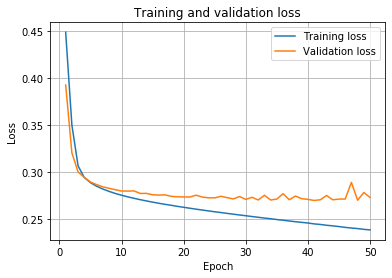

In [10]:
history_dict = history.history
train_loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(train_loss) + 1)
plt.title('Training and validation loss')
plt.plot(epochs, train_loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

In [11]:
X_test = vectorize_sequences(test['Lyric'])
Y_test = vectorize_sequences(test['Genre'], 6) 


# compute loss and accuracy on test data
score = model.evaluate(X_test, Y_test, verbose=1)
print("Test score:", score[0])
print("Test accuracy:", score[1])

Found 59624 unique tokens.
Found 8 unique tokens.
24785/24785 [==============================] - 5s 215us/step
Test score: 0.4128058219355202
Test accuracy: 0.8080019354820251


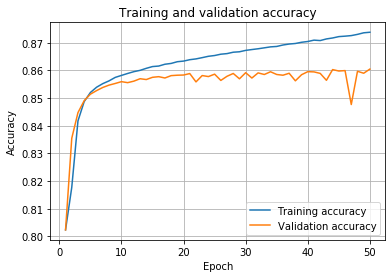

In [12]:
history_dict = history.history
train_acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']

epochs = range(1, len(train_loss) + 1)
plt.title('Training and validation accuracy')
plt.plot(epochs, train_acc, label='Training accuracy')
plt.plot(epochs, val_acc, label='Validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()

# Enhanced FFN

In [13]:

#tfidf_vectorizer=TfidfVectorizer(stop_words="english", use_idf=True, max_features=10000)
tfidf_vectorizer=TfidfVectorizer(use_idf=True, max_features=10000) 
# just send in all your docs here
xtrain_tfidf = tfidf_vectorizer.fit(train['Lyric'])

X_train = xtrain_tfidf.transform(train['Lyric'])
y_train = vectorize_labels(train['Genre'])



In [21]:
model_tfidf = models.Sequential()
model_tfidf.add(layers.Dense(128, activation='relu', input_shape=(10000,)))
model_tfidf.add(layers.Dense(64, activation='relu'))
model_tfidf.add(layers.Dense(32, activation='relu'))
model_tfidf.add(layers.Dense(6, activation='softmax'))
model_tfidf.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy'])
model_tfidf.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 128)               1280128   
_________________________________________________________________
dense_9 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_10 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_11 (Dense)             (None, 12)                396       
_________________________________________________________________
dense_12 (Dense)             (None, 6)                 78        
Total params: 1,290,938
Trainable params: 1,290,938
Non-trainable params: 0
_________________________________________________________________


In [15]:
history_tfidf = model_tfidf.fit(X_train, y_train, epochs=50, batch_size=100, validation_split=0.2)

Train on 79310 samples, validate on 19828 samples
Epoch 1/50
79310/79310 [==============================] - 18s 223us/step - loss: 1.2306 - accuracy: 0.4865 - val_loss: 1.0586 - val_accuracy: 0.4859
Epoch 2/50
79310/79310 [==============================] - 21s 267us/step - loss: 1.0467 - accuracy: 0.4875 - val_loss: 1.0409 - val_accuracy: 0.4859
Epoch 3/50
79310/79310 [==============================] - 21s 267us/step - loss: 1.0366 - accuracy: 0.4875 - val_loss: 1.0320 - val_accuracy: 0.4859
Epoch 4/50
79310/79310 [==============================] - 21s 264us/step - loss: 1.0257 - accuracy: 0.4875 - val_loss: 1.0176 - val_accuracy: 0.4859
Epoch 5/50
79310/79310 [==============================] - 20s 255us/step - loss: 1.0007 - accuracy: 0.4887 - val_loss: 0.9788 - val_accuracy: 0.4928
Epoch 6/50
79310/79310 [==============================] - 22s 281us/step - loss: 0.9419 - accuracy: 0.5375 - val_loss: 0.9054 - val_accuracy: 0.5767
Epoch 7/50
79310/79310 [==============================] 

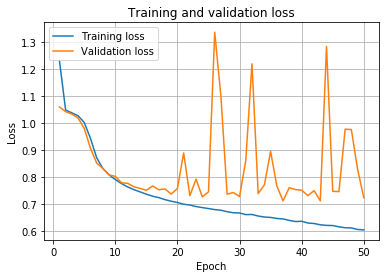

In [17]:
history_dict = history_tfidf.history
train_loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(train_loss) + 1)
plt.title('Training and validation loss')
plt.plot(epochs, train_loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

In [19]:
xtest_tfidf = tfidf_vectorizer.fit(test['Lyric'])

X_test = xtest_tfidf.transform(test['Lyric'])


Y_test = vectorize_labels(test['Genre'])

# compute loss and accuracy on test data
score = model_tfidf.evaluate(X_test, Y_test, verbose=1)
print("Test score:", score[0])
print("Test accuracy:", score[1])

24785/24785 [==============================] - 4s 163us/step
Test score: 1.4607541321505697
Test accuracy: 0.4649989902973175


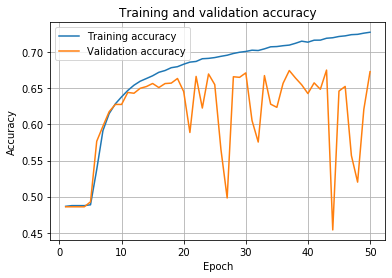

In [20]:
history_dict = history_tfidf.history
train_acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']

epochs = range(1, len(train_loss) + 1)
plt.title('Training and validation accuracy')
plt.plot(epochs, train_acc, label='Training accuracy')
plt.plot(epochs, val_acc, label='Validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()